In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

print(torch.__version__)

1.10.2


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
# dataset

mnist_train = datasets.MNIST(root='./mnist/',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)
mnist_test = datasets.MNIST(root='./mnist/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [7]:
# dataloader

BATCH_SIZE = 256

train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)

In [10]:
# model

class CNNClass(nn.Module):
    
    def __init__(self, 
                 name='cnn', 
                 xdim=[1, 28, 28], 
                 ksize=3, 
                 cdims=[32, 64], 
                 hdims=[1024, 128], 
                 ydim=10, 
                 USE_BATCHNORM=False):
        super(CNNClass, self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM
        
        # CNN
        self.layers = []
        prev_cdim = self.xdim[0] # 왜 xdim 전체가 아니라 xdim[0]만 넘겨줌???
        
        for cdim in self.cdims:
            self.layers.append(nn.Conv2d(in_channels=prev_cdim, 
                                         out_channels=cdim, 
                                         kernel_size=self.ksize, 
                                         stride=(1, 1), 
                                         padding=self.ksize//2))
            
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim))
            self.layers.append(nn.ReLU(True))
            self.layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
            self.layers.append(nn.Dropout2d(p=0.5))
            prev_cdim = cdim
            
        # FC
        self.layers.append(nn.Flatten())
        prev_hdim = prev_cdim * (self.xdim[1]//(2**len(self.cdims))) * (self.xdim[2]//(2**len(self.cdims)))
        
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim, 
                                         hdim, 
                                         bias=True))
            
            self.layers.append(nn.ReLU(True))
            prev_hdim = hdim
            
        # Final layer
        self.layers.append(nn.Linear(prev_hdim, 
                                     self.ydim, 
                                     bias=True))
        
        # concat all layers
        self.net = nn.Sequential()
        for l_idx, layer in enumerate(self.layers):
            layer_name = type(layer).__name__ + str(l_idx)
            self.net.add_module(layer_name, layer)
            
        self.init_param()
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d): 
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        return self.net(x)
    
C = CNNClass(name='cnn', 
             xdim=[1, 28, 28], 
             ksize=3, 
             cdims=[32, 64], 
             hdims=[32], 
             ydim=10).to(device)

loss = nn.CrossEntropyLoss()

optm = optim.Adam(C.parameters(), lr=1e-3)    


In [11]:
# check parameters

n_param = 0

for param_name, param in C.named_parameters():
    
    n_param += len(param.reshape(-1))
    
    print(param_name, param.shape)

net.Conv2d0.weight torch.Size([32, 1, 3, 3])
net.Conv2d0.bias torch.Size([32])
net.Conv2d4.weight torch.Size([64, 32, 3, 3])
net.Conv2d4.bias torch.Size([64])
net.Linear9.weight torch.Size([32, 3136])
net.Linear9.bias torch.Size([32])
net.Linear11.weight torch.Size([10, 32])
net.Linear11.bias torch.Size([10])


In [13]:
# net.Conv2d0.weight torch.Size([32, 1, 3, 3])
# 32 channels to make, grayscale, 3x3 kernel

In [14]:
C

CNNClass(
  (net): Sequential(
    (Conv2d0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU1): ReLU(inplace=True)
    (MaxPool2d2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (Dropout2d3): Dropout2d(p=0.5, inplace=False)
    (Conv2d4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU5): ReLU(inplace=True)
    (MaxPool2d6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (Dropout2d7): Dropout2d(p=0.5, inplace=False)
    (Flatten8): Flatten(start_dim=1, end_dim=-1)
    (Linear9): Linear(in_features=3136, out_features=32, bias=True)
    (ReLU10): ReLU(inplace=True)
    (Linear11): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [20]:
# list(C.named_parameters())

In [22]:
C.net.Conv2d0

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [24]:
# C.net.Conv2d0.weight

In [26]:
# simple forward pass

np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)

x_numpy = np.random.rand(2, 1, 28, 28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch)
y_numpy = y_torch.detach().cpu().numpy()

print (f'x_numpy: {x_numpy.shape}\n{x_numpy}\n')
print (f'x_torch: {x_torch.shape}\n{x_torch}\n')
print (f'y_torch: {y_torch.shape}\n{y_torch}\n')
print (f'y_numpy: {y_numpy.shape}\n{y_numpy}\n')

x_numpy: (2, 1, 28, 28)
[[[[0.269 0.604 0.301 ... 0.45  0.996 0.833]
   [0.622 0.73  0.923 ... 0.382 0.577 0.116]
   [0.438 0.585 0.179 ... 0.252 0.723 0.323]
   ...
   [0.778 0.637 0.211 ... 0.683 0.075 0.386]
   [0.217 0.544 0.122 ... 0.554 0.075 0.764]
   [0.122 0.747 0.801 ... 0.722 0.581 0.246]]]


 [[[0.613 0.871 0.29  ... 0.195 0.104 0.521]
   [0.153 0.686 0.088 ... 0.079 0.602 0.626]
   [0.006 0.926 0.828 ... 0.018 0.911 0.569]
   ...
   [0.559 0.926 0.452 ... 0.26  0.209 0.23 ]
   [0.627 0.483 0.523 ... 0.418 0.566 0.122]
   [0.594 0.218 0.548 ... 0.721 0.367 0.211]]]]

x_torch: torch.Size([2, 1, 28, 28])
tensor([[[[0.269, 0.604, 0.301,  ..., 0.450, 0.996, 0.833],
          [0.622, 0.730, 0.923,  ..., 0.382, 0.577, 0.116],
          [0.438, 0.585, 0.179,  ..., 0.252, 0.723, 0.323],
          ...,
          [0.778, 0.637, 0.211,  ..., 0.683, 0.075, 0.386],
          [0.217, 0.544, 0.122,  ..., 0.554, 0.075, 0.764],
          [0.122, 0.747, 0.801,  ..., 0.722, 0.581, 0.246]]],



In [30]:
# eval func

def func_eval(model, data_iter, device):

    with torch.no_grad():
        model.eval()
        # torch.no_grad & model.eval(): evaluation mode
        # turns off dropout and BN
        
        n_correct, n_total = 0, 0
        
        for X, y in data_iter:
            
            y = y.to(device)
            output = model(X.view(-1, 1, 28, 28).to(device))
            _, y_pred = torch.max(output, 1)
            
            n_correct += (y_pred==y).sum().item()
            n_total += X.size(0)
            
        acc = n_correct / n_total
        
        model.train()
        
    return acc


In [31]:
C.init_param() # init params

train_acc = func_eval(C, train_iter, device)
test_acc = func_eval(C, test_iter, device)

print(train_acc)
print(test_acc)

0.1207
0.122


In [34]:
# train

C.init_param()
C.train()

EPOCHS = 10
print_every = 1

for epoch in range(EPOCHS):
    
    loss_val_sum = 0
    
    for X, y in tqdm(train_iter):
        
        output = C.forward(X.view(-1, 1, 28, 28).to(device))
        loss_out = loss(output, y.to(device))
        
        optm.zero_grad() # reset grad
        
        loss_out.backward() # backprop
        
        optm.step() # optimizer update
        
        loss_val_sum += loss_out
        
    loss_val_avg = loss_val_sum/len(train_iter)
    
    if ((epoch%print_every)==0) or (epoch==(EPOCH-1)):
        
        train_acc = func_eval(C, train_iter, device)
        test_acc = func_eval(C, test_iter, device)
        
        print(f'epoch: {epoch}, loss: {loss_val_avg}')
        print(f'train_acc: {train_acc}, test_acc: {test_acc}')
    

  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 0, loss: 0.5797686576843262
train_acc: 0.9509166666666666, test_acc: 0.9528


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 1, loss: 0.18328051269054413
train_acc: 0.97165, test_acc: 0.9719


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 2, loss: 0.13692587614059448
train_acc: 0.97825, test_acc: 0.9788


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 3, loss: 0.1117444708943367
train_acc: 0.98165, test_acc: 0.9813


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 4, loss: 0.09953202307224274
train_acc: 0.98265, test_acc: 0.9811


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 5, loss: 0.08988141268491745
train_acc: 0.9861333333333333, test_acc: 0.9853


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 6, loss: 0.08028259873390198
train_acc: 0.9869333333333333, test_acc: 0.9857


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 7, loss: 0.07437752932310104
train_acc: 0.9882166666666666, test_acc: 0.9859


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 8, loss: 0.06986752152442932
train_acc: 0.9894833333333334, test_acc: 0.9879


  0%|          | 0/235 [00:00<?, ?it/s]

epoch: 9, loss: 0.06607001274824142
train_acc: 0.9896833333333334, test_acc: 0.9868


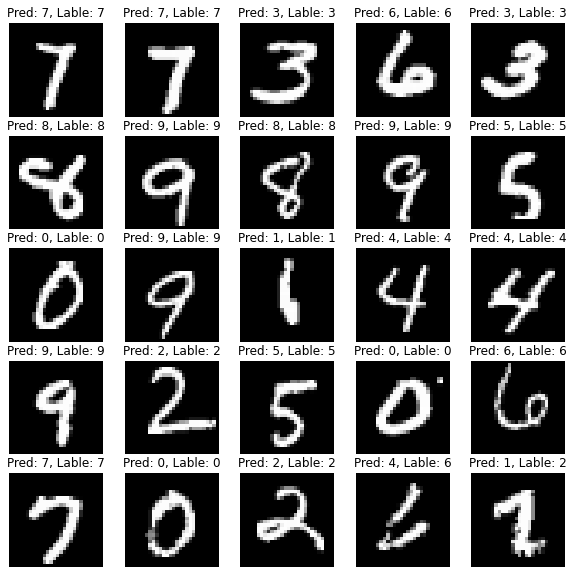

In [36]:
# test

n_samples = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_samples, replace=False)

test_X = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    C.eval()
    output = C.forward(test_X.view(-1, 1, 28, 28).type(torch.float).to(device)/255.)
    
y_pred = output.argmax(axis=1)

plt.figure(figsize=(10, 10))
for idx in range(n_samples):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_X[idx], cmap='gray')
    plt.axis('off')
    plt.title(f'Pred: {y_pred[idx]}, Lable: {test_y[idx]}')
plt.show()